#### Image Classification

'''Problem Statement: The goal of the project is to classify images of fruits and vegetables into their respective categories accurately 
                       using a CNN model developed in TensorFlow.
                       The dataset contains a diverse range of fruits and vegetables images, making it challenging to classify them accurately. 
                       
                       #Motivation behind selecting the PS
                       The project is motivated by increasing availability of large image datasets and the rise of deep 
                       learning techniques, there is a growing need to develop accurate and efficient image classification systems. 
                       Classifying images has numerous real-world applications, In the case of the given dataset, accurate image 
                       classification of fruits and vegetables can help in food production, agriculture, and nutrition-related industries.
                       Manual sorting of fruits and vegetables in a warehouse or grocery store is a tedious and challenging task. 
                       An image classification system can automate this process, saving time and reducing errors.                 


    Dataset: Fruits and Vegetables Image Recognition Dataset
    link: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
    Description: This dataset contains images of the following food items:
    fruits- banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
    vegetables- cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage,lettuce,
                spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato,  
                paprika, jalepeno, ginger, garlic, peas, eggplant.
                
    ref: https://github.com/priteshkeleven/Food101/blob/master/transfer_learning_food101.ipynb'''

In [ ]:
!pip install tensorflow==2.9.1

In [18]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

^C


In [19]:
import tensorflow as tf
import zipfile
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [20]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import datetime

In [21]:
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instance to store log files.
    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"
    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [22]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img / 255.
    else:
        return img

In [23]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.
    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.
    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).
    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.
    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0]  

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  
           yticks=np.arange(n_classes),
           xticklabels=labels, 
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [24]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: 
        pred_class = class_names[pred.argmax()] 
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] 

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [25]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [26]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
             plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
             plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [27]:
def unzip_data(filename):
    """
    Unzips filename into the current working directory.
    Args:
      filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

In [28]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str): target directory
    Returns:
      A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [29]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results


In [30]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [31]:
#unzip_data("fruit-and-vegetable-image-recognition.zip")

In [32]:
train_dir = "train"
test_dir = "test"
validation_dir = "validation"

In [33]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               image_size=IMG_SIZE,
                                                                               label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False)

Found 3115 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [34]:
checkpoint_path = "checkpoint/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [35]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.) # Rescale images required for ResNet50v2
], name="data_augmentation")

In [36]:
# Setup the base mode and freeze its layers (to extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layres
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) 
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [37]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                46116     
                                                                 
Total params: 4,095,687
Trainable params: 46,116
Non-trainabl

In [20]:
base_model_history = model.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history")])

Saving TensorBoard log files to: transfer_learning/base_model_history/20230327-230049
Epoch 1/5


2023-03-27 23:00:53.945674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:00:54.185190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:00:54.353226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:00:58.312580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


 1/98 [..............................] - ETA: 19:44 - loss: 3.7494 - accuracy: 0.0312

2023-03-27 23:01:01.414546: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 2/98 [..............................] - ETA: 55s - loss: 3.6250 - accuracy: 0.0469  

2023-03-27 23:01:02.186400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 43s - loss: 3.5202 - accuracy: 0.0703

2023-03-27 23:01:04.983013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:05.014093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 42s - loss: 3.4862 - accuracy: 0.0799

2023-03-27 23:01:05.603025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 32s - loss: 3.2481 - accuracy: 0.1728

2023-03-27 23:01:08.051899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 29s - loss: 3.1331 - accuracy: 0.2116

2023-03-27 23:01:09.601440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 24s - loss: 2.9496 - accuracy: 0.2792

2023-03-27 23:01:12.024603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 23s - loss: 2.9031 - accuracy: 0.2959

2023-03-27 23:01:12.978866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 22s - loss: 2.8348 - accuracy: 0.3232

2023-03-27 23:01:13.697366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


41/98 [===========>..................] - ETA: 19s - loss: 2.7365 - accuracy: 0.3491

2023-03-27 23:01:15.452392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:15.509460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 18s - loss: 2.6634 - accuracy: 0.3729

2023-03-27 23:01:16.349833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:16.351682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 14s - loss: 2.5100 - accuracy: 0.4182

2023-03-27 23:01:19.493404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 12s - loss: 2.4289 - accuracy: 0.4406

2023-03-27 23:01:20.717835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 11s - loss: 2.3856 - accuracy: 0.4529

2023-03-27 23:01:21.754487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


69/98 [====================>.........] - ETA: 9s - loss: 2.3113 - accuracy: 0.4701

2023-03-27 23:01:23.343032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:23.496101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


74/98 [=====================>........] - ETA: 7s - loss: 2.2418 - accuracy: 0.4878

2023-03-27 23:01:24.779414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


85/98 [=========================>....] - ETA: 4s - loss: 2.1092 - accuracy: 0.5217

2023-03-27 23:01:27.892557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 44s 325ms/step - loss: 1.9979 - accuracy: 0.5419 - val_loss: 0.8609 - val_accuracy: 0.9062
Epoch 2/5


2023-03-27 23:01:33.809829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:34.047829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:34.196668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/98 [..............................] - ETA: 24s - loss: 0.9889 - accuracy: 0.8125 

2023-03-27 23:01:35.161305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 1.0582 - accuracy: 0.7500

2023-03-27 23:01:37.282713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:37.300343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 26s - loss: 1.0837 - accuracy: 0.7273

2023-03-27 23:01:37.726017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 22s - loss: 1.0528 - accuracy: 0.7463

2023-03-27 23:01:39.411697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/98 [=====>........................] - ETA: 21s - loss: 1.0398 - accuracy: 0.7455

2023-03-27 23:01:40.401068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 17s - loss: 1.0206 - accuracy: 0.7510

2023-03-27 23:01:42.292290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 16s - loss: 1.0015 - accuracy: 0.7595

2023-03-27 23:01:43.006212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 16s - loss: 1.0106 - accuracy: 0.7555

2023-03-27 23:01:43.377934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 14s - loss: 0.9895 - accuracy: 0.7652

2023-03-27 23:01:44.529394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:44.544272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/98 [===========>..................] - ETA: 14s - loss: 0.9823 - accuracy: 0.7671

2023-03-27 23:01:45.295337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:45.304287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 12s - loss: 0.9826 - accuracy: 0.7662

2023-03-27 23:01:48.342962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 0.9800 - accuracy: 0.7632

2023-03-27 23:01:49.968091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 10s - loss: 0.9651 - accuracy: 0.7669

2023-03-27 23:01:51.431794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 0.9455 - accuracy: 0.7721

2023-03-27 23:01:52.948852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:01:53.102220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 0.9318 - accuracy: 0.7769

2023-03-27 23:01:54.181414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


83/98 [========================>.....] - ETA: 4s - loss: 0.9096 - accuracy: 0.7812

2023-03-27 23:01:57.145334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 28s 274ms/step - loss: 0.8839 - accuracy: 0.7862 - val_loss: 0.4958 - val_accuracy: 0.9375
Epoch 3/5


2023-03-27 23:02:02.264865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:02.521988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:02.694732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/98 [..............................] - ETA: 33s - loss: 0.5410 - accuracy: 0.8750 

2023-03-27 23:02:03.645716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 27s - loss: 0.6553 - accuracy: 0.8472

2023-03-27 23:02:05.682812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:05.703174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 26s - loss: 0.7065 - accuracy: 0.8125

2023-03-27 23:02:06.093070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 22s - loss: 0.7113 - accuracy: 0.8160

2023-03-27 23:02:07.752410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 20s - loss: 0.7055 - accuracy: 0.8196

2023-03-27 23:02:08.828254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 19s - loss: 0.7156 - accuracy: 0.8125

2023-03-27 23:02:10.863799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 17s - loss: 0.7032 - accuracy: 0.8191

2023-03-27 23:02:11.845873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 17s - loss: 0.7005 - accuracy: 0.8188

2023-03-27 23:02:12.231381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 15s - loss: 0.7063 - accuracy: 0.8165

2023-03-27 23:02:13.526957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:13.577913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/98 [===========>..................] - ETA: 15s - loss: 0.7127 - accuracy: 0.8185

2023-03-27 23:02:14.659208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:14.667093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


53/98 [===============>..............] - ETA: 12s - loss: 0.6936 - accuracy: 0.8213

2023-03-27 23:02:17.331227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 10s - loss: 0.6925 - accuracy: 0.8254

2023-03-27 23:02:18.630180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 10s - loss: 0.6893 - accuracy: 0.8263

2023-03-27 23:02:19.719118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 0.6838 - accuracy: 0.8272

2023-03-27 23:02:21.136798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:21.297611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


74/98 [=====================>........] - ETA: 6s - loss: 0.6730 - accuracy: 0.8311

2023-03-27 23:02:22.355328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


84/98 [========================>.....] - ETA: 3s - loss: 0.6626 - accuracy: 0.8330

2023-03-27 23:02:24.339058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 27s 264ms/step - loss: 0.6494 - accuracy: 0.8350 - val_loss: 0.3810 - val_accuracy: 0.9688
Epoch 4/5


2023-03-27 23:02:29.651676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:29.908799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:30.066331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 25s - loss: 0.5155 - accuracy: 0.8750

2023-03-27 23:02:30.879768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 23s - loss: 0.5615 - accuracy: 0.8472

2023-03-27 23:02:32.502434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:32.534169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 21s - loss: 0.5615 - accuracy: 0.8494

2023-03-27 23:02:32.932148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 17s - loss: 0.5753 - accuracy: 0.8472

2023-03-27 23:02:34.047450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/98 [=====>........................] - ETA: 16s - loss: 0.5736 - accuracy: 0.8497

2023-03-27 23:02:34.713394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 14s - loss: 0.5535 - accuracy: 0.8615

2023-03-27 23:02:36.625578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 13s - loss: 0.5498 - accuracy: 0.8627

2023-03-27 23:02:37.376759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.5529 - accuracy: 0.8625

2023-03-27 23:02:37.763605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


41/98 [===========>..................] - ETA: 11s - loss: 0.5746 - accuracy: 0.8514

2023-03-27 23:02:38.948380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:38.968391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 12s - loss: 0.5647 - accuracy: 0.8547

2023-03-27 23:02:39.509807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:39.518611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


53/98 [===============>..............] - ETA: 10s - loss: 0.5626 - accuracy: 0.8555

2023-03-27 23:02:42.214126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 8s - loss: 0.5601 - accuracy: 0.8516

2023-03-27 23:02:43.538379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 8s - loss: 0.5594 - accuracy: 0.8523

2023-03-27 23:02:44.283142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


69/98 [====================>.........] - ETA: 6s - loss: 0.5533 - accuracy: 0.8542

2023-03-27 23:02:45.488355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:45.644592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 5s - loss: 0.5522 - accuracy: 0.8562

2023-03-27 23:02:46.731728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


83/98 [========================>.....] - ETA: 3s - loss: 0.5474 - accuracy: 0.8577

2023-03-27 23:02:48.656483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 24s 226ms/step - loss: 0.5405 - accuracy: 0.8597 - val_loss: 0.3257 - val_accuracy: 1.0000
Epoch 5/5


2023-03-27 23:02:53.181429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:53.430567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:53.600664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/98 [..............................] - ETA: 49s - loss: 0.4121 - accuracy: 0.9219 

2023-03-27 23:02:54.661162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 29s - loss: 0.4559 - accuracy: 0.8889

2023-03-27 23:02:56.650937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:02:56.666843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 24s - loss: 0.4786 - accuracy: 0.8828

2023-03-27 23:02:57.062747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 20s - loss: 0.5099 - accuracy: 0.8698

2023-03-27 23:02:58.205258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 18s - loss: 0.5018 - accuracy: 0.8693

2023-03-27 23:02:59.165371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 16s - loss: 0.4958 - accuracy: 0.8729

2023-03-27 23:03:01.089994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 15s - loss: 0.4944 - accuracy: 0.8722

2023-03-27 23:03:01.907757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 15s - loss: 0.4912 - accuracy: 0.8741

2023-03-27 23:03:02.296018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


41/98 [===========>..................] - ETA: 13s - loss: 0.4998 - accuracy: 0.8697

2023-03-27 23:03:03.460585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:03:03.482651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 13s - loss: 0.5072 - accuracy: 0.8670

2023-03-27 23:03:04.024406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:03:04.030266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


53/98 [===============>..............] - ETA: 10s - loss: 0.4984 - accuracy: 0.8744

2023-03-27 23:03:06.351415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 9s - loss: 0.4964 - accuracy: 0.8755

2023-03-27 23:03:07.729832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 8s - loss: 0.4905 - accuracy: 0.8775

2023-03-27 23:03:08.690208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 7s - loss: 0.4882 - accuracy: 0.8745

2023-03-27 23:03:10.170894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:03:10.335748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


73/98 [=====================>........] - ETA: 5s - loss: 0.4837 - accuracy: 0.8754

2023-03-27 23:03:11.378230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


83/98 [========================>.....] - ETA: 3s - loss: 0.4756 - accuracy: 0.8773

2023-03-27 23:03:13.551654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 25s 237ms/step - loss: 0.4736 - accuracy: 0.8774 - val_loss: 0.2897 - val_accuracy: 0.9688


In [21]:
# Evaluate on whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

 5/12 [===========>..................] - ETA: 1s - loss: 0.3528 - accuracy: 0.8813

2023-03-27 23:03:18.360609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s - loss: 0.3070 - accuracy: 0.9018

2023-03-27 23:03:18.801526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 253ms/step - loss: 0.2903 - accuracy: 0.9164


[0.29034921526908875, 0.9164345264434814]

In [ ]:
'''The accuracy of the base model is 91.60%'''

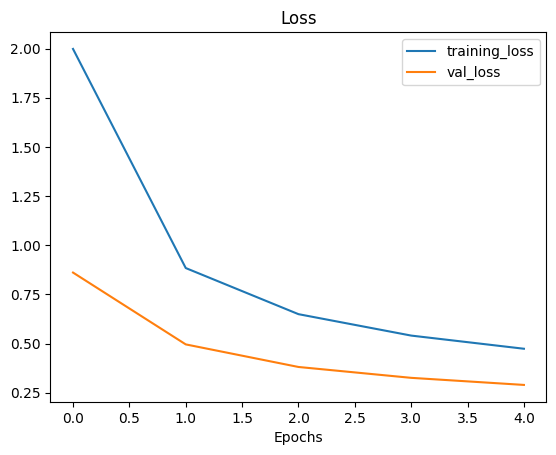

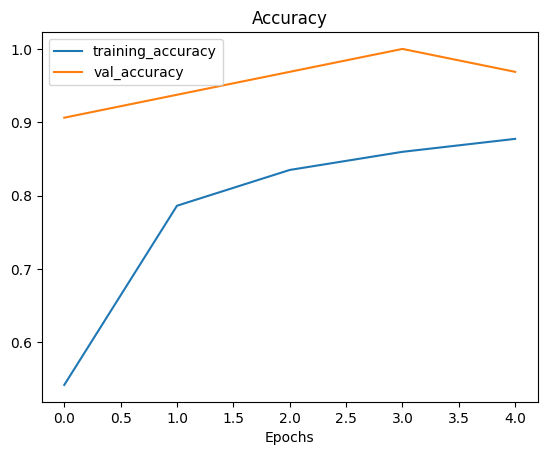

In [22]:
plot_loss_curves(base_model_history)

In [23]:
model.save("base_model.h5")

In [24]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [25]:
for i, layer in enumerate(base_model.layers[-10:]):
    print(i, layer.name, layer.trainable)

0 block7a_se_squeeze False
1 block7a_se_reshape False
2 block7a_se_reduce False
3 block7a_se_expand False
4 block7a_se_excite False
5 block7a_project_conv True
6 block7a_project_bn True
7 top_conv True
8 top_bn True
9 top_activation True


In [26]:
# Recompiling model with lower learning_rate
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                46116     
                                                                 
Total params: 4,095,687
Trainable params: 827,556
Non-trainab

In [28]:
initial_epochs = 5
history_fine_tuned_base_model = model.fit(train_data,
                                        epochs=initial_epochs + 5,
                                        validation_data=validation_data,
                                        validation_steps=int(0.15 * len(validation_data)),
                                        initial_epoch=base_model_history.epoch[-1],
                                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="history_fine_tuned_base_model")])

Saving TensorBoard log files to: transfer_learning/history_fine_tuned_base_model/20230327-230409
Epoch 5/10


2023-03-27 23:04:13.576014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:13.802895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:13.958147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 21s - loss: 0.4498 - accuracy: 0.8438 

2023-03-27 23:04:15.768121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 22s - loss: 0.4377 - accuracy: 0.8656

2023-03-27 23:04:17.743954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:17.768219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 23s - loss: 0.4276 - accuracy: 0.8722

2023-03-27 23:04:18.095465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 18s - loss: 0.4382 - accuracy: 0.8713

2023-03-27 23:04:19.302121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 18s - loss: 0.4191 - accuracy: 0.8807

2023-03-27 23:04:20.356491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 16s - loss: 0.4186 - accuracy: 0.8813

2023-03-27 23:04:22.347971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 15s - loss: 0.4125 - accuracy: 0.8824

2023-03-27 23:04:23.223240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 14s - loss: 0.4131 - accuracy: 0.8813

2023-03-27 23:04:23.613436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


41/98 [===========>..................] - ETA: 13s - loss: 0.4037 - accuracy: 0.8819

2023-03-27 23:04:24.884991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:24.908658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 12s - loss: 0.4150 - accuracy: 0.8799

2023-03-27 23:04:25.428224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:25.434943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.4103 - accuracy: 0.8778 

2023-03-27 23:04:27.837654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 8s - loss: 0.4064 - accuracy: 0.8801

2023-03-27 23:04:28.826683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 7s - loss: 0.4023 - accuracy: 0.8823

2023-03-27 23:04:29.541678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 6s - loss: 0.3932 - accuracy: 0.8857

2023-03-27 23:04:30.700849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:30.838927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.3911 - accuracy: 0.8849

2023-03-27 23:04:31.839383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


85/98 [=========================>....] - ETA: 2s - loss: 0.3820 - accuracy: 0.8886

2023-03-27 23:04:33.747364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 29s 231ms/step - loss: 0.3787 - accuracy: 0.8880 - val_loss: 0.1988 - val_accuracy: 0.9688
Epoch 6/10


2023-03-27 23:04:38.721589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:38.971179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:39.128004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 21s - loss: 0.3200 - accuracy: 0.9062

2023-03-27 23:04:39.995266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 21s - loss: 0.3080 - accuracy: 0.9031

2023-03-27 23:04:41.850232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:41.871392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 22s - loss: 0.3061 - accuracy: 0.9006

2023-03-27 23:04:42.259429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 18s - loss: 0.3119 - accuracy: 0.9080

2023-03-27 23:04:43.524588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 17s - loss: 0.3130 - accuracy: 0.9105

2023-03-27 23:04:44.506270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 15s - loss: 0.3183 - accuracy: 0.9062

2023-03-27 23:04:46.421203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 14s - loss: 0.3186 - accuracy: 0.9045

2023-03-27 23:04:47.179551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 13s - loss: 0.3227 - accuracy: 0.9029

2023-03-27 23:04:47.596227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/98 [===========>..................] - ETA: 12s - loss: 0.3232 - accuracy: 0.9010

2023-03-27 23:04:48.710543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:48.737968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 11s - loss: 0.3267 - accuracy: 0.8977

2023-03-27 23:04:49.246392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:49.272251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


53/98 [===============>..............] - ETA: 10s - loss: 0.3302 - accuracy: 0.8992

2023-03-27 23:04:51.352526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 8s - loss: 0.3283 - accuracy: 0.8972

2023-03-27 23:04:52.467602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 7s - loss: 0.3255 - accuracy: 0.8984

2023-03-27 23:04:53.220471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 6s - loss: 0.3201 - accuracy: 0.8996

2023-03-27 23:04:54.417917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:04:54.571795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.3194 - accuracy: 0.9001

2023-03-27 23:04:55.713308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


84/98 [========================>.....] - ETA: 3s - loss: 0.3201 - accuracy: 0.8999

2023-03-27 23:04:57.659892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 218ms/step - loss: 0.3154 - accuracy: 0.9002 - val_loss: 0.1881 - val_accuracy: 0.9375
Epoch 7/10


2023-03-27 23:05:01.745632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:02.013117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:02.187535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 19s - loss: 0.1956 - accuracy: 0.9167

2023-03-27 23:05:02.913251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 19s - loss: 0.2362 - accuracy: 0.9132

2023-03-27 23:05:04.492242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:04.514311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 19s - loss: 0.2487 - accuracy: 0.9091

2023-03-27 23:05:04.936640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 19s - loss: 0.2704 - accuracy: 0.9004

2023-03-27 23:05:06.081860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/98 [=====>........................] - ETA: 17s - loss: 0.2701 - accuracy: 0.9031

2023-03-27 23:05:06.865619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 15s - loss: 0.2784 - accuracy: 0.9052

2023-03-27 23:05:08.754590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 14s - loss: 0.2879 - accuracy: 0.8996

2023-03-27 23:05:09.519900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.2795 - accuracy: 0.9036

2023-03-27 23:05:09.905124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


40/98 [===========>..................] - ETA: 12s - loss: 0.2896 - accuracy: 0.9031

2023-03-27 23:05:11.151199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:11.173585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 12s - loss: 0.2863 - accuracy: 0.9048

2023-03-27 23:05:11.992336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:11.997370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.2799 - accuracy: 0.9097

2023-03-27 23:05:14.431706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 8s - loss: 0.2734 - accuracy: 0.9114

2023-03-27 23:05:15.451256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 7s - loss: 0.2763 - accuracy: 0.9096

2023-03-27 23:05:16.329981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 6s - loss: 0.2683 - accuracy: 0.9129

2023-03-27 23:05:17.559359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:17.712504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


74/98 [=====================>........] - ETA: 5s - loss: 0.2674 - accuracy: 0.9147

2023-03-27 23:05:18.778448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.2592 - accuracy: 0.9168

2023-03-27 23:05:20.766165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 223ms/step - loss: 0.2635 - accuracy: 0.9149 - val_loss: 0.1940 - val_accuracy: 0.9375
Epoch 8/10


2023-03-27 23:05:25.037332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:25.310720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:25.474507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 23s - loss: 0.1960 - accuracy: 0.9271

2023-03-27 23:05:26.510289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 22s - loss: 0.2480 - accuracy: 0.9156

2023-03-27 23:05:28.235274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:28.256187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 22s - loss: 0.2548 - accuracy: 0.9119

2023-03-27 23:05:28.661486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 19s - loss: 0.2487 - accuracy: 0.9154

2023-03-27 23:05:29.776006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/98 [=====>........................] - ETA: 18s - loss: 0.2557 - accuracy: 0.9094

2023-03-27 23:05:30.524359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 15s - loss: 0.2726 - accuracy: 0.9052

2023-03-27 23:05:32.473977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 14s - loss: 0.2633 - accuracy: 0.9072

2023-03-27 23:05:33.261462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 13s - loss: 0.2579 - accuracy: 0.9106

2023-03-27 23:05:33.655171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


41/98 [===========>..................] - ETA: 12s - loss: 0.2632 - accuracy: 0.9085

2023-03-27 23:05:34.804570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:34.823940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 11s - loss: 0.2620 - accuracy: 0.9112

2023-03-27 23:05:35.414692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:35.449076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 10s - loss: 0.2559 - accuracy: 0.9129

2023-03-27 23:05:37.507344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 8s - loss: 0.2533 - accuracy: 0.9133

2023-03-27 23:05:38.516706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 7s - loss: 0.2526 - accuracy: 0.9153

2023-03-27 23:05:39.299710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 6s - loss: 0.2467 - accuracy: 0.9187

2023-03-27 23:05:40.581228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:40.734796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.2425 - accuracy: 0.9192

2023-03-27 23:05:41.825896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


85/98 [=========================>....] - ETA: 2s - loss: 0.2400 - accuracy: 0.9202

2023-03-27 23:05:43.793278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 218ms/step - loss: 0.2443 - accuracy: 0.9188 - val_loss: 0.1854 - val_accuracy: 0.9062
Epoch 9/10


2023-03-27 23:05:48.121524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:48.382344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:48.569291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 23s - loss: 0.1747 - accuracy: 0.9688

2023-03-27 23:05:49.443550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 22s - loss: 0.2302 - accuracy: 0.9250

2023-03-27 23:05:51.267878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:51.290817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 22s - loss: 0.2231 - accuracy: 0.9318

2023-03-27 23:05:51.703152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 19s - loss: 0.2350 - accuracy: 0.9306

2023-03-27 23:05:52.985654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 16s - loss: 0.2355 - accuracy: 0.9280

2023-03-27 23:05:53.834703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 14s - loss: 0.2300 - accuracy: 0.9294

2023-03-27 23:05:55.813619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 14s - loss: 0.2269 - accuracy: 0.9301

2023-03-27 23:05:56.588785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 13s - loss: 0.2338 - accuracy: 0.9265

2023-03-27 23:05:57.028398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 12s - loss: 0.2468 - accuracy: 0.9186

2023-03-27 23:05:58.400556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:58.430219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 11s - loss: 0.2455 - accuracy: 0.9205

2023-03-27 23:05:58.953262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:05:58.963626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.2329 - accuracy: 0.9233

2023-03-27 23:06:01.031343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 8s - loss: 0.2338 - accuracy: 0.9224

2023-03-27 23:06:02.036846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 7s - loss: 0.2331 - accuracy: 0.9226

2023-03-27 23:06:02.862068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


69/98 [====================>.........] - ETA: 6s - loss: 0.2269 - accuracy: 0.9244

2023-03-27 23:06:04.088115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:04.257113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.2233 - accuracy: 0.9272

2023-03-27 23:06:05.369861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.2222 - accuracy: 0.9284

2023-03-27 23:06:07.425147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 24s 223ms/step - loss: 0.2190 - accuracy: 0.9287 - val_loss: 0.1791 - val_accuracy: 0.9062
Epoch 10/10


2023-03-27 23:06:11.575509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:11.838361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:12.002680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9479

2023-03-27 23:06:12.723644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 23s - loss: 0.1937 - accuracy: 0.9479

2023-03-27 23:06:14.398806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:14.417562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 19s - loss: 0.2049 - accuracy: 0.9375

2023-03-27 23:06:14.807934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/98 [====>.........................] - ETA: 16s - loss: 0.2154 - accuracy: 0.9293

2023-03-27 23:06:16.024550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 15s - loss: 0.2156 - accuracy: 0.9280

2023-03-27 23:06:16.766690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9274

2023-03-27 23:06:18.723428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.2167 - accuracy: 0.9295

2023-03-27 23:06:19.477901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 12s - loss: 0.2180 - accuracy: 0.9282

2023-03-27 23:06:19.871410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 11s - loss: 0.2184 - accuracy: 0.9261

2023-03-27 23:06:21.177179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:21.200627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 10s - loss: 0.2195 - accuracy: 0.9260

2023-03-27 23:06:21.721212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:21.727071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.2131 - accuracy: 0.9295

2023-03-27 23:06:23.830033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.2114 - accuracy: 0.9308

2023-03-27 23:06:24.889268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.2079 - accuracy: 0.9332

2023-03-27 23:06:25.706416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 5s - loss: 0.2054 - accuracy: 0.9339

2023-03-27 23:06:26.955268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:06:27.112276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.2016 - accuracy: 0.9362

2023-03-27 23:06:28.145089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


84/98 [========================>.....] - ETA: 3s - loss: 0.2000 - accuracy: 0.9371

2023-03-27 23:06:30.310508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 219ms/step - loss: 0.2024 - accuracy: 0.9371 - val_loss: 0.1662 - val_accuracy: 0.9062


In [29]:
# Evaluate on whole dataset
all_classes_fine_tune_results = model.evaluate(test_data)
all_classes_fine_tune_results

 5/12 [===========>..................] - ETA: 1s - loss: 0.2041 - accuracy: 0.8938

2023-03-27 23:06:34.909556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s - loss: 0.1611 - accuracy: 0.9241

2023-03-27 23:06:35.355742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 198ms/step - loss: 0.1591 - accuracy: 0.9359


[0.1590796411037445, 0.9359331727027893]

In [ ]:
'''The accuracy of the model after unlocking of the last 5 layers is 93.59%'''

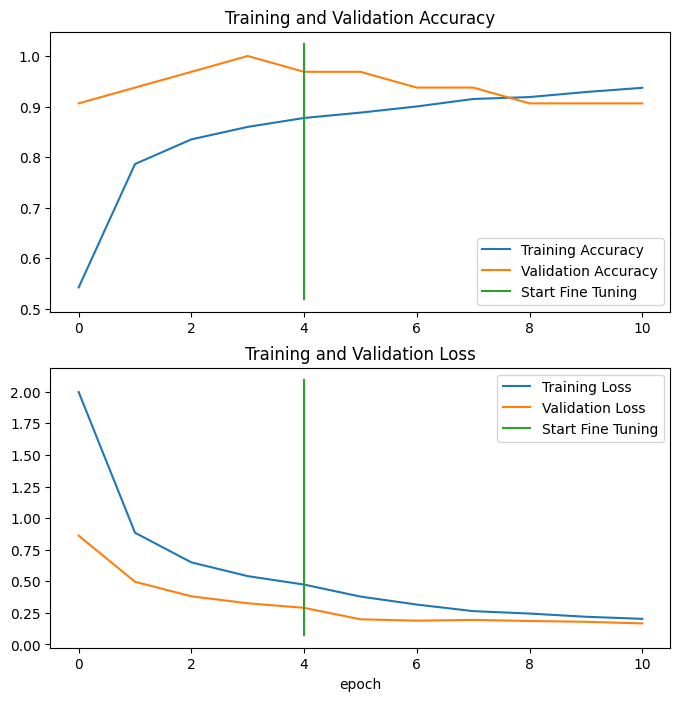

In [30]:
# Compare the histories with fine tuning
compare_historys(original_history=base_model_history,
                new_history=history_fine_tuned_base_model,
                initial_epochs=5)

In [31]:
# Save our model in h5 format
model.save("model/fine_tuned_model_v1.h5")

In [35]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("model/fine_tuned_model_v1.h5")

In [36]:
# Evaluate loaded models
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

 5/12 [===========>..................] - ETA: 1s - loss: 0.2041 - accuracy: 0.8938

2023-03-27 23:07:59.072042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.1611 - accuracy: 0.9241

2023-03-27 23:07:59.460554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 160ms/step - loss: 0.1591 - accuracy: 0.9359


[0.15908397734165192, 0.9359331727027893]

In [37]:
# Model results before loading
all_classes_fine_tune_results

[0.1590796411037445, 0.9359331727027893]

#### Fine tuning with more unlocked layers

In [38]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [39]:
for i, layer in enumerate(base_model.layers[-20:]):
    print(i, layer.name, layer.trainable)

0 block6d_project_conv False
1 block6d_project_bn False
2 block6d_drop False
3 block6d_add False
4 block7a_expand_conv False
5 block7a_expand_bn False
6 block7a_expand_activation False
7 block7a_dwconv False
8 block7a_bn False
9 block7a_activation False
10 block7a_se_squeeze True
11 block7a_se_reshape True
12 block7a_se_reduce True
13 block7a_se_expand True
14 block7a_se_excite True
15 block7a_project_conv True
16 block7a_project_bn True
17 top_conv True
18 top_bn True
19 top_activation True


In [40]:
# Recompiling model with lower learning_rate
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                46116     
                                                                 
Total params: 4,095,687
Trainable params: 939,348
Non-trainab

In [42]:
initial_epochs = 5
history_fine_tuned_base_model = model.fit(train_data,
                                        epochs=initial_epochs + 5,
                                        validation_data=validation_data,
                                        validation_steps=int(0.15 * len(validation_data)),
                                        initial_epoch=base_model_history.epoch[-1],
                                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="history_fine_tuned_base_model")])

Saving TensorBoard log files to: transfer_learning/history_fine_tuned_base_model/20230327-230800
Epoch 5/10


2023-03-27 23:08:04.531888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:04.754664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:04.894135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9896

2023-03-27 23:08:05.852260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 16s - loss: 0.1748 - accuracy: 0.9438

2023-03-27 23:08:07.236565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:07.249930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9349

2023-03-27 23:08:07.579769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/98 [====>.........................] - ETA: 13s - loss: 0.2067 - accuracy: 0.9326

2023-03-27 23:08:08.642054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 12s - loss: 0.1975 - accuracy: 0.9361

2023-03-27 23:08:09.249534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 12s - loss: 0.1992 - accuracy: 0.9335

2023-03-27 23:08:10.999805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 11s - loss: 0.1972 - accuracy: 0.9311

2023-03-27 23:08:11.693549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 11s - loss: 0.1983 - accuracy: 0.9314

2023-03-27 23:08:12.082260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 10s - loss: 0.2029 - accuracy: 0.9302

2023-03-27 23:08:13.205894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:13.232259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 9s - loss: 0.2034 - accuracy: 0.9299

2023-03-27 23:08:13.727980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:13.748282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.1912 - accuracy: 0.9347

2023-03-27 23:08:15.605841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 7s - loss: 0.1857 - accuracy: 0.9365

2023-03-27 23:08:16.504560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.1869 - accuracy: 0.9370

2023-03-27 23:08:17.238083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 4s - loss: 0.1828 - accuracy: 0.9393

2023-03-27 23:08:18.354560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:18.506376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.1814 - accuracy: 0.9391

2023-03-27 23:08:19.452747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.1805 - accuracy: 0.9390

2023-03-27 23:08:21.319720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 25s 201ms/step - loss: 0.1798 - accuracy: 0.9374 - val_loss: 0.1683 - val_accuracy: 0.9062
Epoch 6/10


2023-03-27 23:08:26.032310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:26.303628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:26.483928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 19s - loss: 0.1053 - accuracy: 0.9583

2023-03-27 23:08:27.262765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9469

2023-03-27 23:08:28.840265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:28.861907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 19s - loss: 0.1268 - accuracy: 0.9489

2023-03-27 23:08:29.267610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 17s - loss: 0.1445 - accuracy: 0.9444

2023-03-27 23:08:30.680294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 17s - loss: 0.1559 - accuracy: 0.9446

2023-03-27 23:08:31.522127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 14s - loss: 0.1644 - accuracy: 0.9435

2023-03-27 23:08:33.379066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 14s - loss: 0.1632 - accuracy: 0.9439

2023-03-27 23:08:34.169693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 13s - loss: 0.1655 - accuracy: 0.9444

2023-03-27 23:08:34.562587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.1718 - accuracy: 0.9419

2023-03-27 23:08:35.756792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:35.778404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 11s - loss: 0.1728 - accuracy: 0.9403

2023-03-27 23:08:36.328875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:36.339980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 8s - loss: 0.1686 - accuracy: 0.9431

2023-03-27 23:08:38.501135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.1666 - accuracy: 0.9436

2023-03-27 23:08:39.533551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 7s - loss: 0.1628 - accuracy: 0.9448

2023-03-27 23:08:40.307954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 5s - loss: 0.1588 - accuracy: 0.9478

2023-03-27 23:08:41.504575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:41.667120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.1610 - accuracy: 0.9475

2023-03-27 23:08:42.704594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.1593 - accuracy: 0.9484

2023-03-27 23:08:44.622256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 214ms/step - loss: 0.1596 - accuracy: 0.9486 - val_loss: 0.1622 - val_accuracy: 0.9062
Epoch 7/10


2023-03-27 23:08:48.501951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:48.757404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:48.907597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 16s - loss: 0.1106 - accuracy: 0.9583

2023-03-27 23:08:49.735266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9406

2023-03-27 23:08:51.356204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:51.395601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 18s - loss: 0.1534 - accuracy: 0.9427

2023-03-27 23:08:51.779710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/98 [====>.........................] - ETA: 15s - loss: 0.1318 - accuracy: 0.9556

2023-03-27 23:08:52.939146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 14s - loss: 0.1244 - accuracy: 0.9606

2023-03-27 23:08:53.604998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 13s - loss: 0.1387 - accuracy: 0.9531

2023-03-27 23:08:55.512198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 12s - loss: 0.1395 - accuracy: 0.9518

2023-03-27 23:08:56.281931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 13s - loss: 0.1381 - accuracy: 0.9523

2023-03-27 23:08:56.749839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.1412 - accuracy: 0.9499

2023-03-27 23:08:57.985869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:58.009728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 10s - loss: 0.1404 - accuracy: 0.9508

2023-03-27 23:08:58.533740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:08:58.542142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 8s - loss: 0.1371 - accuracy: 0.9531

2023-03-27 23:09:00.639733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 7s - loss: 0.1370 - accuracy: 0.9526

2023-03-27 23:09:01.596811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 6s - loss: 0.1383 - accuracy: 0.9517

2023-03-27 23:09:02.428795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 5s - loss: 0.1367 - accuracy: 0.9525

2023-03-27 23:09:03.619099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:03.769841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.1374 - accuracy: 0.9531

2023-03-27 23:09:04.862870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


85/98 [=========================>....] - ETA: 2s - loss: 0.1379 - accuracy: 0.9533

2023-03-27 23:09:06.839254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 22s 212ms/step - loss: 0.1359 - accuracy: 0.9531 - val_loss: 0.1684 - val_accuracy: 0.9062
Epoch 8/10


2023-03-27 23:09:10.774502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:11.051748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:11.213281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 21s - loss: 0.1060 - accuracy: 1.0000

2023-03-27 23:09:11.973902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 19s - loss: 0.1240 - accuracy: 0.9594

2023-03-27 23:09:13.597146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:13.619257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9609

2023-03-27 23:09:14.016685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/98 [====>.........................] - ETA: 15s - loss: 0.1423 - accuracy: 0.9474

2023-03-27 23:09:15.134095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 14s - loss: 0.1371 - accuracy: 0.9511

2023-03-27 23:09:15.934701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 14s - loss: 0.1281 - accuracy: 0.9563

2023-03-27 23:09:17.831824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.1307 - accuracy: 0.9563

2023-03-27 23:09:18.635197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 12s - loss: 0.1292 - accuracy: 0.9569

2023-03-27 23:09:19.023817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 10s - loss: 0.1270 - accuracy: 0.9581

2023-03-27 23:09:20.180908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:20.208713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 10s - loss: 0.1273 - accuracy: 0.9586

2023-03-27 23:09:20.729873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:20.751687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.1239 - accuracy: 0.9580

2023-03-27 23:09:22.895888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 8s - loss: 0.1250 - accuracy: 0.9582

2023-03-27 23:09:23.867069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 6s - loss: 0.1290 - accuracy: 0.9564

2023-03-27 23:09:24.639775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9576

2023-03-27 23:09:25.873145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:26.035834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.1279 - accuracy: 0.9579

2023-03-27 23:09:27.067906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9582

2023-03-27 23:09:29.300556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 22s 213ms/step - loss: 0.1247 - accuracy: 0.9583 - val_loss: 0.1303 - val_accuracy: 0.9062
Epoch 9/10


2023-03-27 23:09:33.117793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:33.367607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:33.524334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 19s - loss: 0.2102 - accuracy: 0.9375

2023-03-27 23:09:34.367721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 19s - loss: 0.1542 - accuracy: 0.9438

2023-03-27 23:09:36.010701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:36.030905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 19s - loss: 0.1496 - accuracy: 0.9432

2023-03-27 23:09:36.419620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 19s - loss: 0.1347 - accuracy: 0.9522

2023-03-27 23:09:37.896004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 16s - loss: 0.1345 - accuracy: 0.9552

2023-03-27 23:09:38.828934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 15s - loss: 0.1316 - accuracy: 0.9567

2023-03-27 23:09:40.793352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 14s - loss: 0.1362 - accuracy: 0.9559

2023-03-27 23:09:41.578437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 13s - loss: 0.1339 - accuracy: 0.9569

2023-03-27 23:09:41.962659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 11s - loss: 0.1340 - accuracy: 0.9553

2023-03-27 23:09:43.168763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:43.196282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 11s - loss: 0.1323 - accuracy: 0.9556

2023-03-27 23:09:43.711786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:43.714865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 9s - loss: 0.1297 - accuracy: 0.9581

2023-03-27 23:09:45.903438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 8s - loss: 0.1294 - accuracy: 0.9589

2023-03-27 23:09:46.897607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 7s - loss: 0.1260 - accuracy: 0.9591

2023-03-27 23:09:47.652846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 5s - loss: 0.1257 - accuracy: 0.9591

2023-03-27 23:09:48.832764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:49.004576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 5s - loss: 0.1256 - accuracy: 0.9592

2023-03-27 23:09:50.046278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9618

2023-03-27 23:09:52.059984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 217ms/step - loss: 0.1220 - accuracy: 0.9599 - val_loss: 0.1263 - val_accuracy: 0.9375
Epoch 10/10


2023-03-27 23:09:55.989889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:56.249895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:56.415070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 21s - loss: 0.0900 - accuracy: 0.9688

2023-03-27 23:09:57.163976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9375

2023-03-27 23:09:58.885771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:09:58.918591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9427

2023-03-27 23:09:59.282843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/98 [====>.........................] - ETA: 16s - loss: 0.1382 - accuracy: 0.9457

2023-03-27 23:10:00.443975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9470

2023-03-27 23:10:01.112055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 15s - loss: 0.1275 - accuracy: 0.9494

2023-03-27 23:10:02.996987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 13s - loss: 0.1315 - accuracy: 0.9504

2023-03-27 23:10:03.843230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 13s - loss: 0.1293 - accuracy: 0.9523

2023-03-27 23:10:04.278459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.1272 - accuracy: 0.9542

2023-03-27 23:10:05.509137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:05.529854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 11s - loss: 0.1231 - accuracy: 0.9556

2023-03-27 23:10:06.056452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:06.063264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.1182 - accuracy: 0.9585

2023-03-27 23:10:08.200150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.1163 - accuracy: 0.9595

2023-03-27 23:10:09.231895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.1161 - accuracy: 0.9601

2023-03-27 23:10:10.007945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 5s - loss: 0.1126 - accuracy: 0.9617

2023-03-27 23:10:11.291258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:11.466104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.1104 - accuracy: 0.9625

2023-03-27 23:10:12.530119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.1078 - accuracy: 0.9629

2023-03-27 23:10:14.496882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 216ms/step - loss: 0.1116 - accuracy: 0.9618 - val_loss: 0.1493 - val_accuracy: 0.9375


In [43]:
# Evaluate on whole dataset
all_classes_fine_tune_results = model.evaluate(test_data)
all_classes_fine_tune_results

 5/12 [===========>..................] - ETA: 1s - loss: 0.1788 - accuracy: 0.9312

2023-03-27 23:10:19.024600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s - loss: 0.1329 - accuracy: 0.9509

2023-03-27 23:10:19.505006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 214ms/step - loss: 0.1374 - accuracy: 0.9443


[0.13744519650936127, 0.9442896842956543]

In [ ]:
'''The accuracy of the model after unlocking last 10 layers is 94.42%'''

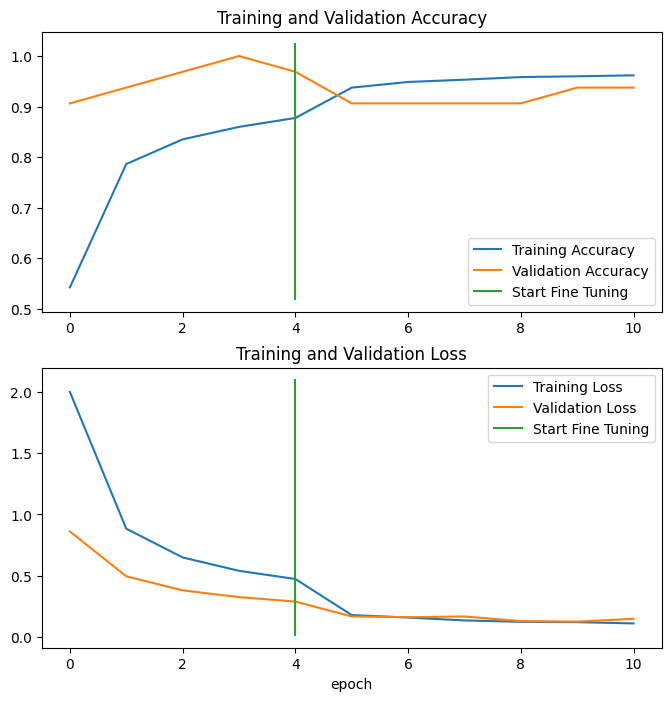

In [44]:
# Compare the histories with fine tuning
compare_historys(original_history=base_model_history,
                new_history=history_fine_tuned_base_model,
                initial_epochs=5)

In [45]:
# Save our model in h5 format
model.save("model/fine_tuned_model_v2.h5")

In [46]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("model/fine_tuned_model_v2.h5")

In [47]:
# Evaluate loaded models
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

 5/12 [===========>..................] - ETA: 0s - loss: 0.1788 - accuracy: 0.9312

2023-03-27 23:10:25.508435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.1329 - accuracy: 0.9509

2023-03-27 23:10:25.937909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 170ms/step - loss: 0.1374 - accuracy: 0.9443


[0.1374487727880478, 0.9442896842956543]

In [48]:
# Model results before loading
all_classes_fine_tune_results

[0.13744519650936127, 0.9442896842956543]

In [49]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [50]:
for i, layer in enumerate(base_model.layers[-30:]):
    print(i, layer.name, layer.trainable)

0 block6d_expand_bn True
1 block6d_expand_activation True
2 block6d_dwconv True
3 block6d_bn True
4 block6d_activation True
5 block6d_se_squeeze True
6 block6d_se_reshape True
7 block6d_se_reduce True
8 block6d_se_expand True
9 block6d_se_excite True
10 block6d_project_conv True
11 block6d_project_bn True
12 block6d_drop True
13 block6d_add True
14 block7a_expand_conv True
15 block7a_expand_bn True
16 block7a_expand_activation True
17 block7a_dwconv True
18 block7a_bn True
19 block7a_activation True
20 block7a_se_squeeze True
21 block7a_se_reshape True
22 block7a_se_reduce True
23 block7a_se_expand True
24 block7a_se_excite True
25 block7a_project_conv True
26 block7a_project_bn True
27 top_conv True
28 top_bn True
29 top_activation True


In [51]:
# Recompiling model with lower learning_rate
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                46116     
                                                                 
Total params: 4,095,687
Trainable params: 1,542,276
Non-train

In [53]:
initial_epochs = 5
history_fine_tuned_base_model = model.fit(train_data,
                                        epochs=initial_epochs + 5,
                                        validation_data=validation_data,
                                        validation_steps=int(0.15 * len(validation_data)),
                                        initial_epoch=base_model_history.epoch[-1],
                                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="history_fine_tuned_base_model")])

Saving TensorBoard log files to: transfer_learning/history_fine_tuned_base_model/20230327-231026
Epoch 5/10


2023-03-27 23:10:31.682509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:31.918309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:32.074951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 31s - loss: 0.0954 - accuracy: 0.9479

2023-03-27 23:10:33.373403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 23s - loss: 0.1212 - accuracy: 0.9375

2023-03-27 23:10:34.910863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:34.929052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 21s - loss: 0.1129 - accuracy: 0.9479

2023-03-27 23:10:35.387268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 18s - loss: 0.1103 - accuracy: 0.9566

2023-03-27 23:10:36.568111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/98 [=====>........................] - ETA: 16s - loss: 0.1147 - accuracy: 0.9554

2023-03-27 23:10:37.227642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 14s - loss: 0.1180 - accuracy: 0.9587

2023-03-27 23:10:39.134174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 13s - loss: 0.1186 - accuracy: 0.9568

2023-03-27 23:10:39.905073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 13s - loss: 0.1183 - accuracy: 0.9566

2023-03-27 23:10:40.314841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.1131 - accuracy: 0.9586

2023-03-27 23:10:41.544341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:41.569939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 11s - loss: 0.1105 - accuracy: 0.9597

2023-03-27 23:10:42.110082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:42.121640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 8s - loss: 0.1151 - accuracy: 0.9593

2023-03-27 23:10:44.211487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.1128 - accuracy: 0.9606

2023-03-27 23:10:45.208044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.1143 - accuracy: 0.9601

2023-03-27 23:10:46.050986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 5s - loss: 0.1135 - accuracy: 0.9604

2023-03-27 23:10:47.257913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:47.428020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.1137 - accuracy: 0.9604

2023-03-27 23:10:48.482144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


85/98 [=========================>....] - ETA: 2s - loss: 0.1146 - accuracy: 0.9596

2023-03-27 23:10:50.457956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 28s 225ms/step - loss: 0.1154 - accuracy: 0.9589 - val_loss: 0.1332 - val_accuracy: 0.9375
Epoch 6/10


2023-03-27 23:10:55.509047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:55.759756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:55.919406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 24s - loss: 0.0907 - accuracy: 0.9792

2023-03-27 23:10:56.716635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 22s - loss: 0.0911 - accuracy: 0.9750

2023-03-27 23:10:58.516137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:10:58.537202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 21s - loss: 0.0943 - accuracy: 0.9740

2023-03-27 23:10:58.932060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 17s - loss: 0.0879 - accuracy: 0.9792

2023-03-27 23:11:00.077912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 16s - loss: 0.0907 - accuracy: 0.9759

2023-03-27 23:11:00.903806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 14s - loss: 0.0871 - accuracy: 0.9746

2023-03-27 23:11:02.839371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.0914 - accuracy: 0.9714

2023-03-27 23:11:03.625370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/98 [==========>...................] - ETA: 12s - loss: 0.0868 - accuracy: 0.9729

2023-03-27 23:11:04.048844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.0951 - accuracy: 0.9702

2023-03-27 23:11:05.252109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:05.283647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 11s - loss: 0.0977 - accuracy: 0.9681

2023-03-27 23:11:05.820476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:05.826482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 8s - loss: 0.0932 - accuracy: 0.9715

2023-03-27 23:11:08.042602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.0971 - accuracy: 0.9698

2023-03-27 23:11:09.046160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 7s - loss: 0.0954 - accuracy: 0.9707

2023-03-27 23:11:09.805812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 5s - loss: 0.0941 - accuracy: 0.9705

2023-03-27 23:11:11.069895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:11.222621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.0919 - accuracy: 0.9704

2023-03-27 23:11:12.310016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.0923 - accuracy: 0.9698

2023-03-27 23:11:14.270690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 216ms/step - loss: 0.0941 - accuracy: 0.9689 - val_loss: 0.0938 - val_accuracy: 0.9688
Epoch 7/10


2023-03-27 23:11:18.142329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:18.396199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:18.584985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/98 [..............................] - ETA: 14s - loss: 0.0511 - accuracy: 1.0000 

2023-03-27 23:11:19.388691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 19s - loss: 0.1141 - accuracy: 0.9594

2023-03-27 23:11:21.057118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:21.086278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 19s - loss: 0.1091 - accuracy: 0.9602

2023-03-27 23:11:21.467945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 20s - loss: 0.1023 - accuracy: 0.9609

2023-03-27 23:11:22.713748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/98 [=====>........................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9643

2023-03-27 23:11:23.486913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 14s - loss: 0.0916 - accuracy: 0.9667

2023-03-27 23:11:25.533723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.0937 - accuracy: 0.9652

2023-03-27 23:11:26.307761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 13s - loss: 0.0926 - accuracy: 0.9662

2023-03-27 23:11:26.717231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.0966 - accuracy: 0.9658

2023-03-27 23:11:27.978382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:28.002529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 11s - loss: 0.0963 - accuracy: 0.9653

2023-03-27 23:11:28.533659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:28.548621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.0937 - accuracy: 0.9659

2023-03-27 23:11:30.664223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.0910 - accuracy: 0.9677

2023-03-27 23:11:31.654372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.0912 - accuracy: 0.9668

2023-03-27 23:11:32.476455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


69/98 [====================>.........] - ETA: 6s - loss: 0.0893 - accuracy: 0.9674

2023-03-27 23:11:33.907179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:34.065859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


74/98 [=====================>........] - ETA: 5s - loss: 0.0884 - accuracy: 0.9683

2023-03-27 23:11:35.105318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.0865 - accuracy: 0.9691

2023-03-27 23:11:37.111717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 217ms/step - loss: 0.0878 - accuracy: 0.9673 - val_loss: 0.1103 - val_accuracy: 0.9688
Epoch 8/10


2023-03-27 23:11:41.124330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:41.379550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:41.547654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 16s - loss: 0.0564 - accuracy: 0.9792

2023-03-27 23:11:42.317044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 20s - loss: 0.0659 - accuracy: 0.9750

2023-03-27 23:11:43.993160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:44.015654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9714

2023-03-27 23:11:44.467821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 17s - loss: 0.0866 - accuracy: 0.9740

2023-03-27 23:11:45.635810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/98 [=====>........................] - ETA: 15s - loss: 0.0812 - accuracy: 0.9759

2023-03-27 23:11:46.413188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 14s - loss: 0.0704 - accuracy: 0.9812

2023-03-27 23:11:48.297597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.0759 - accuracy: 0.9759

2023-03-27 23:11:49.089896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/98 [==========>...................] - ETA: 12s - loss: 0.0753 - accuracy: 0.9762

2023-03-27 23:11:49.503549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 11s - loss: 0.0765 - accuracy: 0.9744

2023-03-27 23:11:50.728601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:50.749710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9742

2023-03-27 23:11:51.273004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:51.282290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 8s - loss: 0.0790 - accuracy: 0.9732

2023-03-27 23:11:53.443506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.0782 - accuracy: 0.9723

2023-03-27 23:11:54.476447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.0768 - accuracy: 0.9736

2023-03-27 23:11:55.250401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 5s - loss: 0.0749 - accuracy: 0.9745

2023-03-27 23:11:56.471481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:11:56.647535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.0749 - accuracy: 0.9733

2023-03-27 23:11:57.729607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


84/98 [========================>.....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9728

2023-03-27 23:11:59.741232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 215ms/step - loss: 0.0750 - accuracy: 0.9727 - val_loss: 0.0681 - val_accuracy: 1.0000
Epoch 9/10


2023-03-27 23:12:03.908759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:04.182646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:04.349877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 22s - loss: 0.0516 - accuracy: 0.9896

2023-03-27 23:12:05.222973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 20s - loss: 0.0702 - accuracy: 0.9781

2023-03-27 23:12:06.939076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:06.959858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 20s - loss: 0.0718 - accuracy: 0.9792

2023-03-27 23:12:07.424733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 18s - loss: 0.0851 - accuracy: 0.9705

2023-03-27 23:12:08.719786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9769

2023-03-27 23:12:09.541918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 15s - loss: 0.0656 - accuracy: 0.9808

2023-03-27 23:12:11.496820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 14s - loss: 0.0673 - accuracy: 0.9795

2023-03-27 23:12:12.297899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 13s - loss: 0.0679 - accuracy: 0.9789

2023-03-27 23:12:12.732730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.0701 - accuracy: 0.9789

2023-03-27 23:12:14.050397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:14.077441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 11s - loss: 0.0714 - accuracy: 0.9783

2023-03-27 23:12:14.667649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:14.672461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 9s - loss: 0.0704 - accuracy: 0.9777

2023-03-27 23:12:16.863657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.0687 - accuracy: 0.9790

2023-03-27 23:12:17.890890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 7s - loss: 0.0689 - accuracy: 0.9784

2023-03-27 23:12:18.685886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 6s - loss: 0.0680 - accuracy: 0.9786

2023-03-27 23:12:19.837774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:20.017524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/98 [======================>.......] - ETA: 4s - loss: 0.0678 - accuracy: 0.9782

2023-03-27 23:12:21.140507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.0686 - accuracy: 0.9775

2023-03-27 23:12:23.170552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 24s 223ms/step - loss: 0.0661 - accuracy: 0.9778 - val_loss: 0.0837 - val_accuracy: 0.9688
Epoch 10/10


2023-03-27 23:12:27.333294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:27.603221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:27.759768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/98 [..............................] - ETA: 14s - loss: 0.0728 - accuracy: 0.9792

2023-03-27 23:12:28.592171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 22s - loss: 0.0633 - accuracy: 0.9781

2023-03-27 23:12:30.483961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:30.516231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 21s - loss: 0.0653 - accuracy: 0.9766

2023-03-27 23:12:30.955955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/98 [====>.........................] - ETA: 17s - loss: 0.0588 - accuracy: 0.9786

2023-03-27 23:12:32.169367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/98 [======>.......................] - ETA: 15s - loss: 0.0570 - accuracy: 0.9796

2023-03-27 23:12:32.845172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9792

2023-03-27 23:12:34.785391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.0565 - accuracy: 0.9812

2023-03-27 23:12:35.595212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/98 [==========>...................] - ETA: 13s - loss: 0.0558 - accuracy: 0.9814

2023-03-27 23:12:36.036201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/98 [============>.................] - ETA: 11s - loss: 0.0586 - accuracy: 0.9797

2023-03-27 23:12:37.316585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:37.343911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 11s - loss: 0.0605 - accuracy: 0.9789

2023-03-27 23:12:37.905931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:37.917383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 8s - loss: 0.0619 - accuracy: 0.9770

2023-03-27 23:12:40.108094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.0619 - accuracy: 0.9775

2023-03-27 23:12:41.131652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 7s - loss: 0.0649 - accuracy: 0.9750

2023-03-27 23:12:41.904184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/98 [====================>.........] - ETA: 6s - loss: 0.0619 - accuracy: 0.9763

2023-03-27 23:12:43.135800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 23:12:43.321898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


75/98 [=====================>........] - ETA: 4s - loss: 0.0650 - accuracy: 0.9758

2023-03-27 23:12:44.372238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


86/98 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9764

2023-03-27 23:12:46.464979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 217ms/step - loss: 0.0628 - accuracy: 0.9775 - val_loss: 0.0627 - val_accuracy: 1.0000


In [54]:
# Evaluate on whole dataset
all_classes_fine_tune_results = model.evaluate(test_data)
all_classes_fine_tune_results

 5/12 [===========>..................] - ETA: 1s - loss: 0.1507 - accuracy: 0.9375

2023-03-27 23:12:50.625364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s - loss: 0.1108 - accuracy: 0.9554

2023-03-27 23:12:51.066388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 201ms/step - loss: 0.1179 - accuracy: 0.9526


[0.11790934205055237, 0.9526462554931641]

In [ ]:
'''The accuracy of the model after unlocking last 30 layers is 95.26%'''

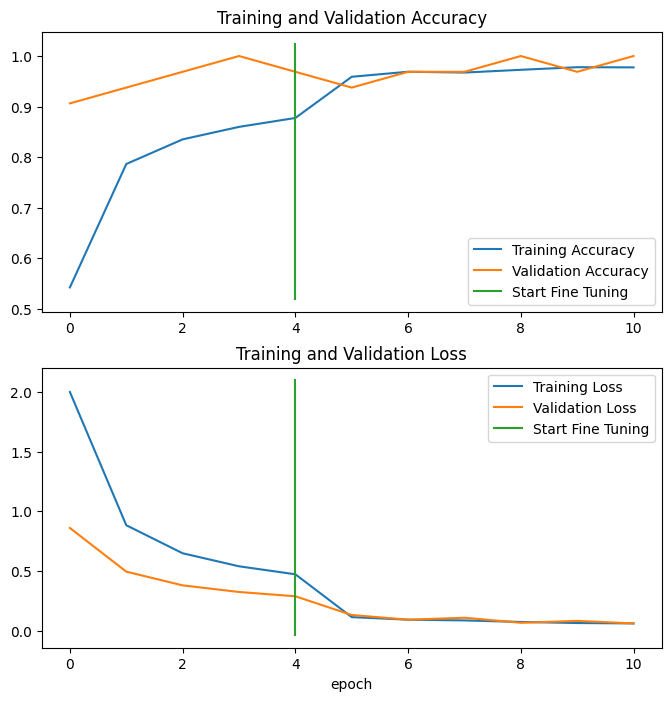

In [55]:
# Compare the histories with fine tuning
compare_historys(original_history=base_model_history,
                new_history=history_fine_tuned_base_model,
                initial_epochs=5)

In [56]:
# Save our model in h5 format
model.save("model/fine_tuned_model_v3.h5")

In [39]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("model/fine_tuned_model_v3.h5")

In [40]:
# Evaluate loaded models
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

12/12 [==============================] - 21s 2s/step - loss: 0.1179 - accuracy: 0.9526


[0.11786361783742905, 0.9526462554931641]

In [59]:
# Model results before loading
all_classes_fine_tune_results

[0.11790934205055237, 0.9526462554931641]

#### Making Predictionas with our model

In [41]:
# Make predictions with model
preds_probs =  loaded_model.predict(test_data, verbose=1) # set verbosity to see how log is left

12/12 [==============================] - 18s 1s/step


In [42]:
len(preds_probs)

359

In [43]:
preds_probs.shape

(359, 36)

In [44]:
preds_probs[:10]

array([[9.99829412e-01, 1.52990752e-13, 4.03821367e-08, 2.83567636e-09,
        2.04998648e-12, 6.39752695e-09, 1.89475116e-10, 8.82976892e-14,
        3.73956972e-08, 9.97772963e-14, 2.08642877e-11, 8.15293166e-09,
        5.63706483e-15, 1.37375712e-12, 1.67310272e-08, 1.18240384e-09,
        2.07367190e-09, 9.15805376e-10, 7.83249243e-10, 2.31953836e-05,
        1.90548216e-10, 1.18002084e-04, 1.46785861e-09, 1.63650166e-05,
        4.99502826e-12, 1.28491553e-12, 1.24493617e-05, 2.33708501e-08,
        1.89642421e-07, 3.72086632e-11, 2.27425204e-10, 3.20093604e-12,
        2.67513817e-10, 1.89606808e-07, 5.73676608e-08, 6.95359930e-08],
       [9.99829412e-01, 1.52990752e-13, 4.03821367e-08, 2.83567636e-09,
        2.04998648e-12, 6.39752695e-09, 1.89475116e-10, 8.82976892e-14,
        3.73956972e-08, 9.97772963e-14, 2.08642877e-11, 8.15293166e-09,
        5.63706483e-15, 1.37375712e-12, 1.67310272e-08, 1.18240384e-09,
        2.07367190e-09, 9.15805376e-10, 7.83249243e-10, 2.31953

In [45]:
preds_probs[0], max(preds_probs[0]), sum(preds_probs[0])

(array([9.99829412e-01, 1.52990752e-13, 4.03821367e-08, 2.83567636e-09,
        2.04998648e-12, 6.39752695e-09, 1.89475116e-10, 8.82976892e-14,
        3.73956972e-08, 9.97772963e-14, 2.08642877e-11, 8.15293166e-09,
        5.63706483e-15, 1.37375712e-12, 1.67310272e-08, 1.18240384e-09,
        2.07367190e-09, 9.15805376e-10, 7.83249243e-10, 2.31953836e-05,
        1.90548216e-10, 1.18002084e-04, 1.46785861e-09, 1.63650166e-05,
        4.99502826e-12, 1.28491553e-12, 1.24493617e-05, 2.33708501e-08,
        1.89642421e-07, 3.72086632e-11, 2.27425204e-10, 3.20093604e-12,
        2.67513817e-10, 1.89606808e-07, 5.73676608e-08, 6.95359930e-08],
       dtype=float32),
 0.9998294,
 1.0000000721410793)

In [46]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"Waht prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the heighest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 36
Waht prediction probability sample 0 looks like:
 [9.99829412e-01 1.52990752e-13 4.03821367e-08 2.83567636e-09
 2.04998648e-12 6.39752695e-09 1.89475116e-10 8.82976892e-14
 3.73956972e-08 9.97772963e-14 2.08642877e-11 8.15293166e-09
 5.63706483e-15 1.37375712e-12 1.67310272e-08 1.18240384e-09
 2.07367190e-09 9.15805376e-10 7.83249243e-10 2.31953836e-05
 1.90548216e-10 1.18002084e-04 1.46785861e-09 1.63650166e-05
 4.99502826e-12 1.28491553e-12 1.24493617e-05 2.33708501e-08
 1.89642421e-07 3.72086632e-11 2.27425204e-10 3.20093604e-12
 2.67513817e-10 1.89606808e-07 5.73676608e-08 6.95359930e-08]
The class with the heighest predicted probability by the model for sample 0: 0


In [47]:
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [48]:
len(pred_classes)

359

In [49]:
y_label = []
for images, labels in test_data.unbatch():
    y_label.append(labels.numpy().argmax()) 
    
y_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
len(y_label)

359

#### Evaluating Model's Predictions

In [51]:
loaded_model_results

[0.11786361783742905, 0.9526462554931641]

In [52]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_label, y_pred=pred_classes)
sklearn_accuracy

0.9526462395543176

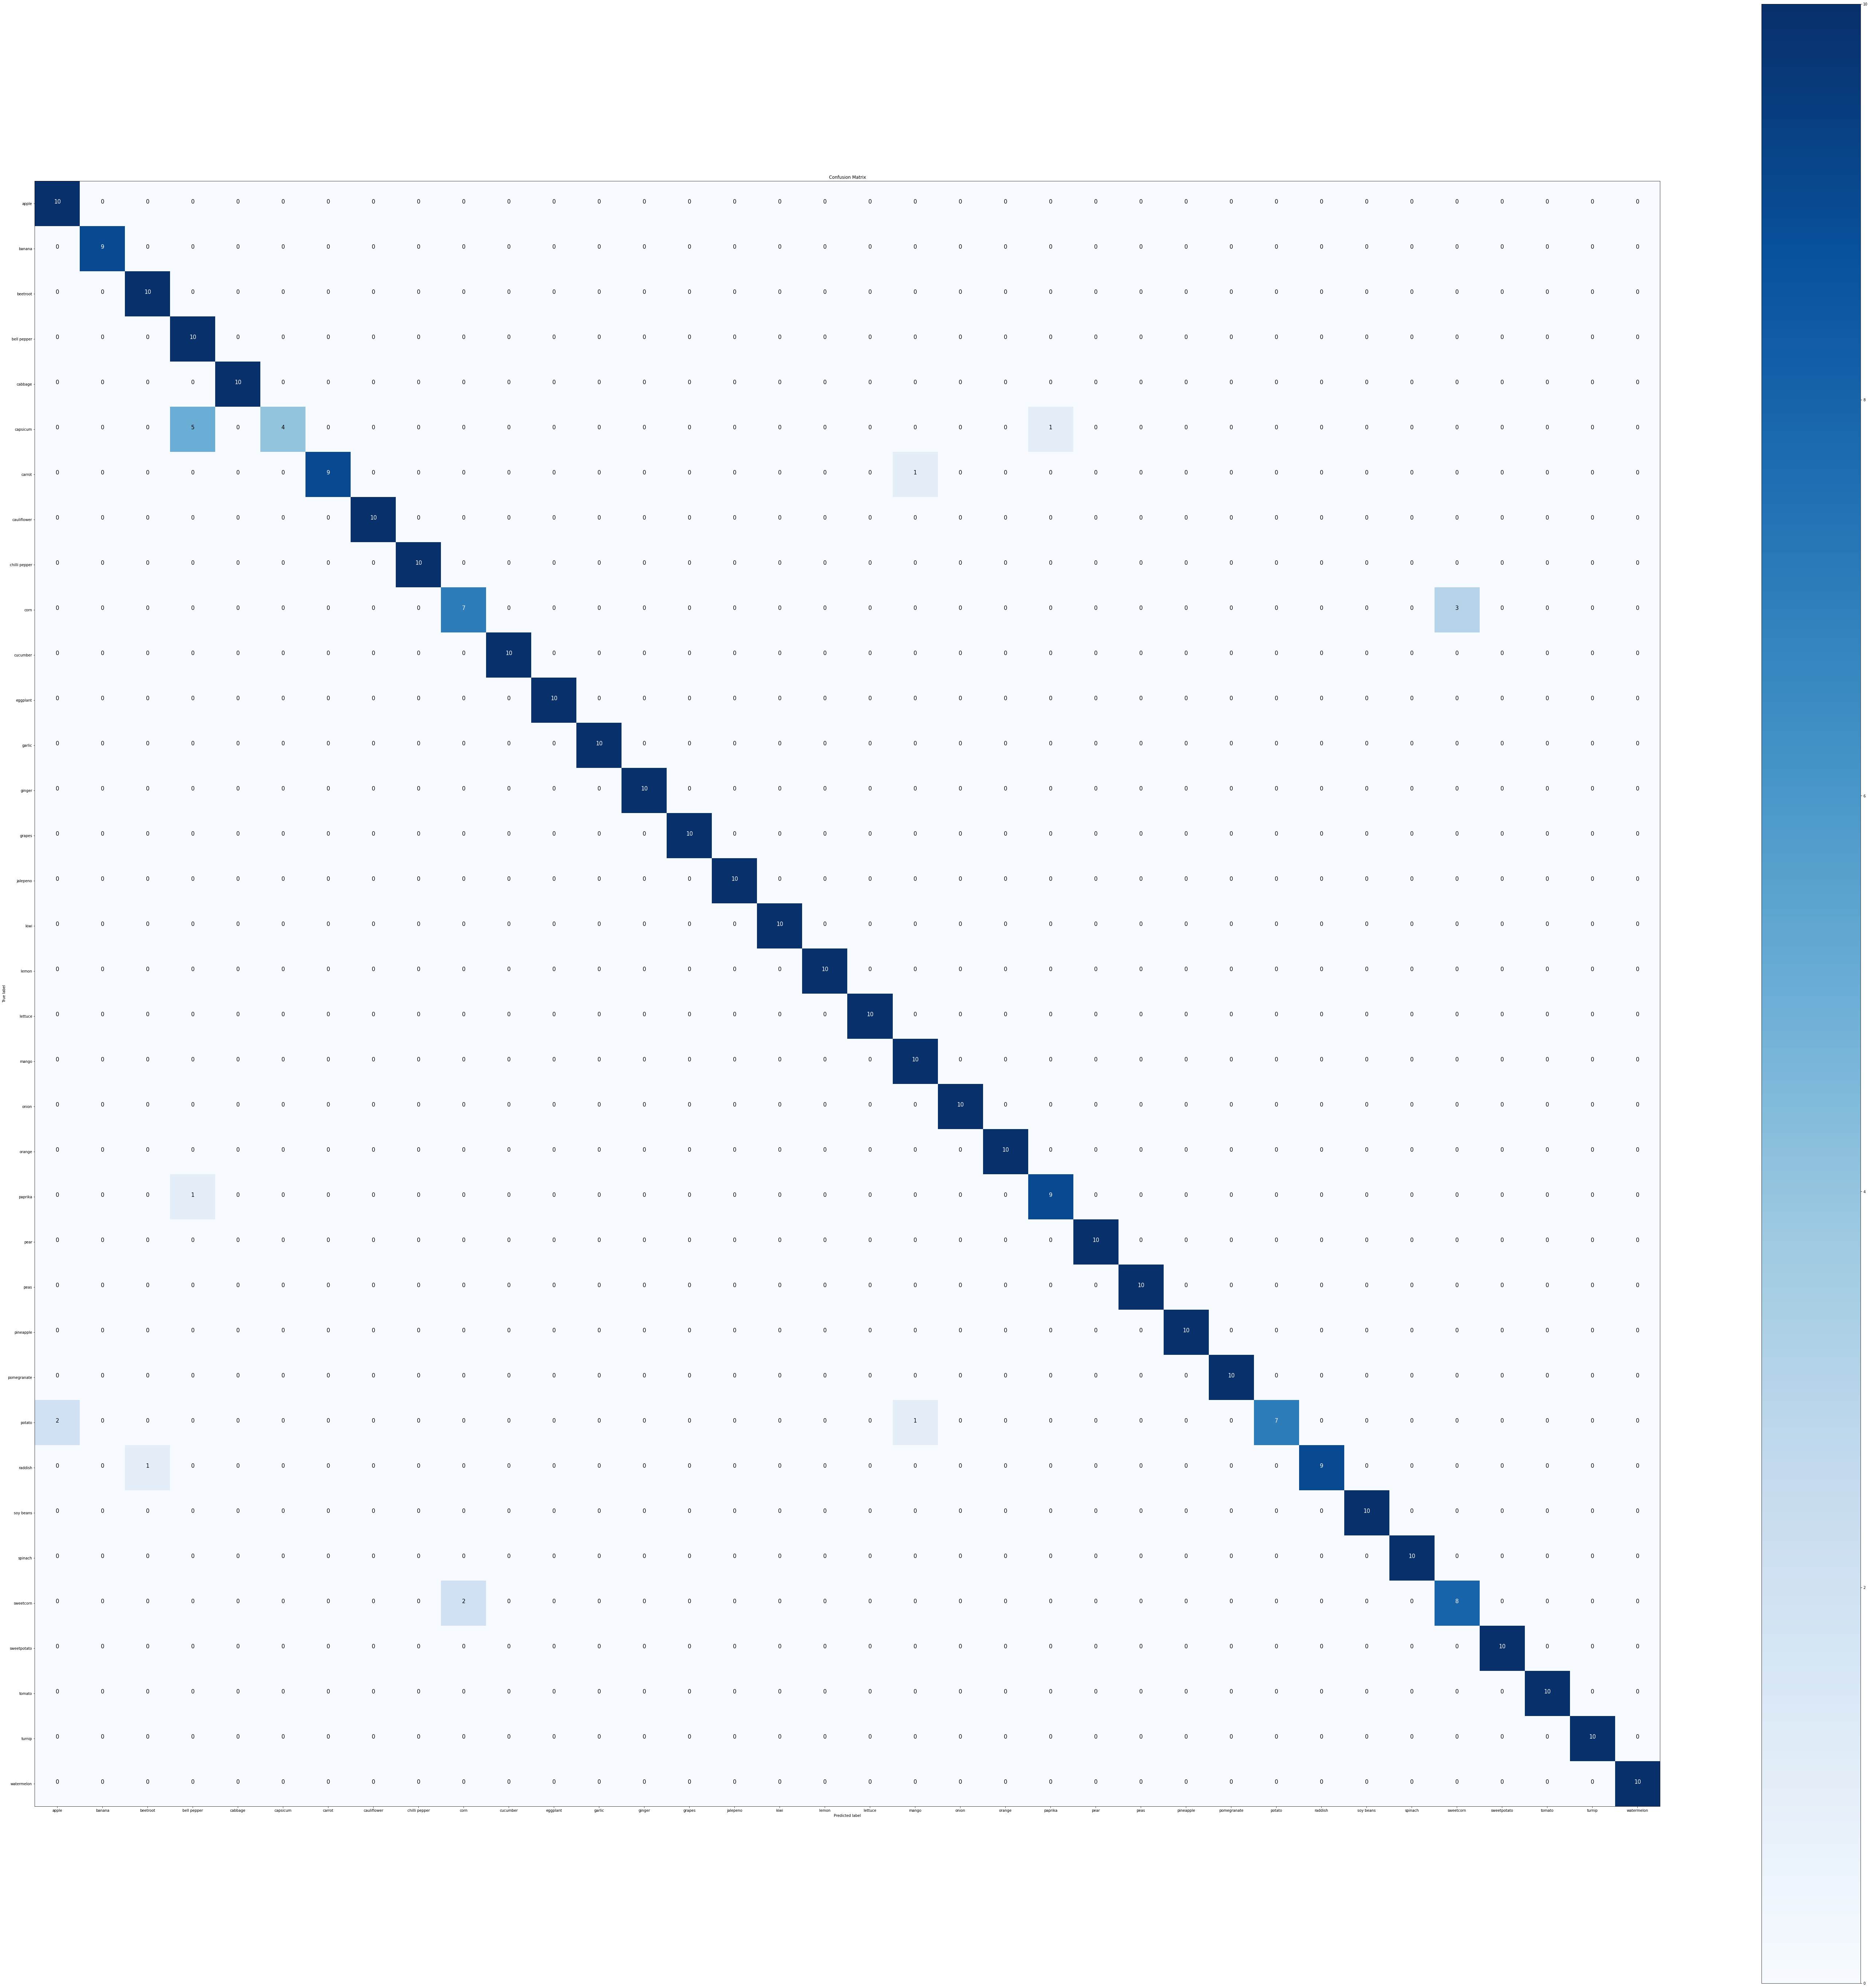

In [53]:
make_confusion_matrix(y_true=y_label, y_pred=pred_classes, classes=test_data.class_names, figsize=(100, 100))

### Classification Report

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_label, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00         9
           2       0.91      1.00      0.95        10
           3       0.62      1.00      0.77        10
           4       1.00      1.00      1.00        10
           5       1.00      0.40      0.57        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.78      0.70      0.74        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

In [55]:
classification_report_dict = classification_report(y_true=y_label, y_pred=pred_classes, output_dict=True)

In [56]:
class_names = test_data.class_names

In [58]:
class_precision_scores = {}


for k, v in classification_report_dict.items():
    if k == "accuracy": 
        break
    else:
        
        class_precision_scores[class_names[int(k)]] = v["precision"]
class_precision_scores

{'apple': 0.8333333333333334,
 'banana': 1.0,
 'beetroot': 0.9090909090909091,
 'bell pepper': 0.625,
 'cabbage': 1.0,
 'capsicum': 1.0,
 'carrot': 1.0,
 'cauliflower': 1.0,
 'chilli pepper': 1.0,
 'corn': 0.7777777777777778,
 'cucumber': 1.0,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 1.0,
 'jalepeno': 1.0,
 'kiwi': 1.0,
 'lemon': 1.0,
 'lettuce': 1.0,
 'mango': 0.8333333333333334,
 'onion': 1.0,
 'orange': 1.0,
 'paprika': 0.9,
 'pear': 1.0,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 1.0,
 'raddish': 1.0,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 0.7272727272727273,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [59]:
import pandas as pd

precision_scores = pd.DataFrame({"class_names": list(class_precision_scores.keys()),
                         "precision": list(class_precision_scores.values())}).sort_values("precision", ascending=False)

In [60]:
precision_scores[:10]

,class_names,precision
18,lettuce,1.0
17,lemon,1.0
34,turnip,1.0
33,tomato,1.0
32,sweetpotato,1.0
30,spinach,1.0
29,soy beans,1.0
28,raddish,1.0
27,potato,1.0
26,pomegranate,1.0


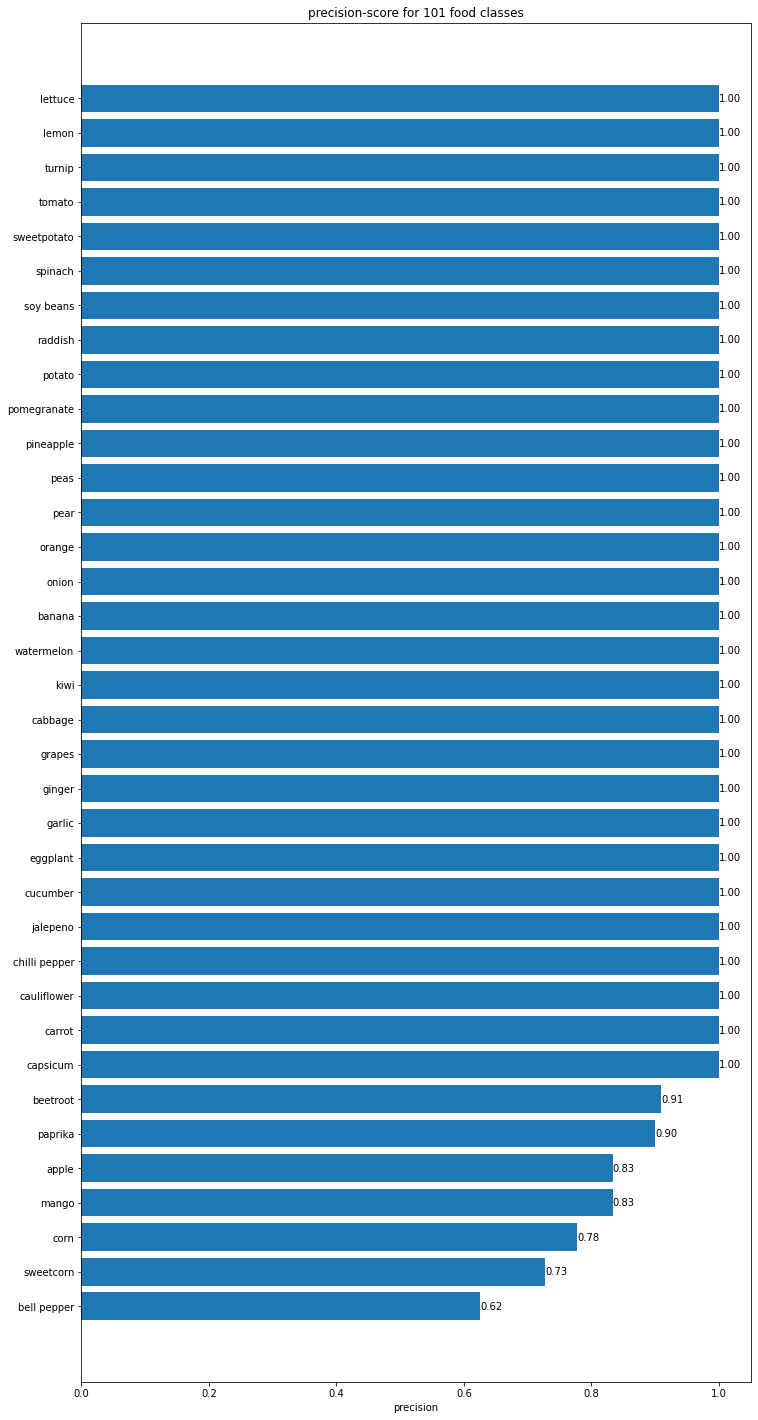

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(precision_scores)), precision_scores["precision"].values)
ax.set_yticks(range(len(precision_scores)))
ax.set_yticklabels(precision_scores["class_names"])
ax.set_xlabel("precision")
ax.set_title("precision-score for 101 food classes")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

In [64]:
class_recall_scores = {}

for k, v in classification_report_dict.items():
    if k == "accuracy": 
        break
    else:
        class_recall_scores[class_names[int(k)]] = v["recall"]
class_recall_scores

{'apple': 1.0,
 'banana': 1.0,
 'beetroot': 1.0,
 'bell pepper': 1.0,
 'cabbage': 1.0,
 'capsicum': 0.4,
 'carrot': 0.9,
 'cauliflower': 1.0,
 'chilli pepper': 1.0,
 'corn': 0.7,
 'cucumber': 1.0,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 1.0,
 'jalepeno': 1.0,
 'kiwi': 1.0,
 'lemon': 1.0,
 'lettuce': 1.0,
 'mango': 1.0,
 'onion': 1.0,
 'orange': 1.0,
 'paprika': 0.9,
 'pear': 1.0,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 0.7,
 'raddish': 0.9,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 0.8,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [65]:
import pandas as pd

recall_scores = pd.DataFrame({"class_names": list(class_recall_scores.keys()),
                         "recall": list(class_recall_scores.values())}).sort_values("recall", ascending=False)

In [66]:
recall_scores[:10]

,class_names,recall
0,apple,1.0
16,kiwi,1.0
34,turnip,1.0
33,tomato,1.0
32,sweetpotato,1.0
30,spinach,1.0
29,soy beans,1.0
26,pomegranate,1.0
25,pineapple,1.0
24,peas,1.0


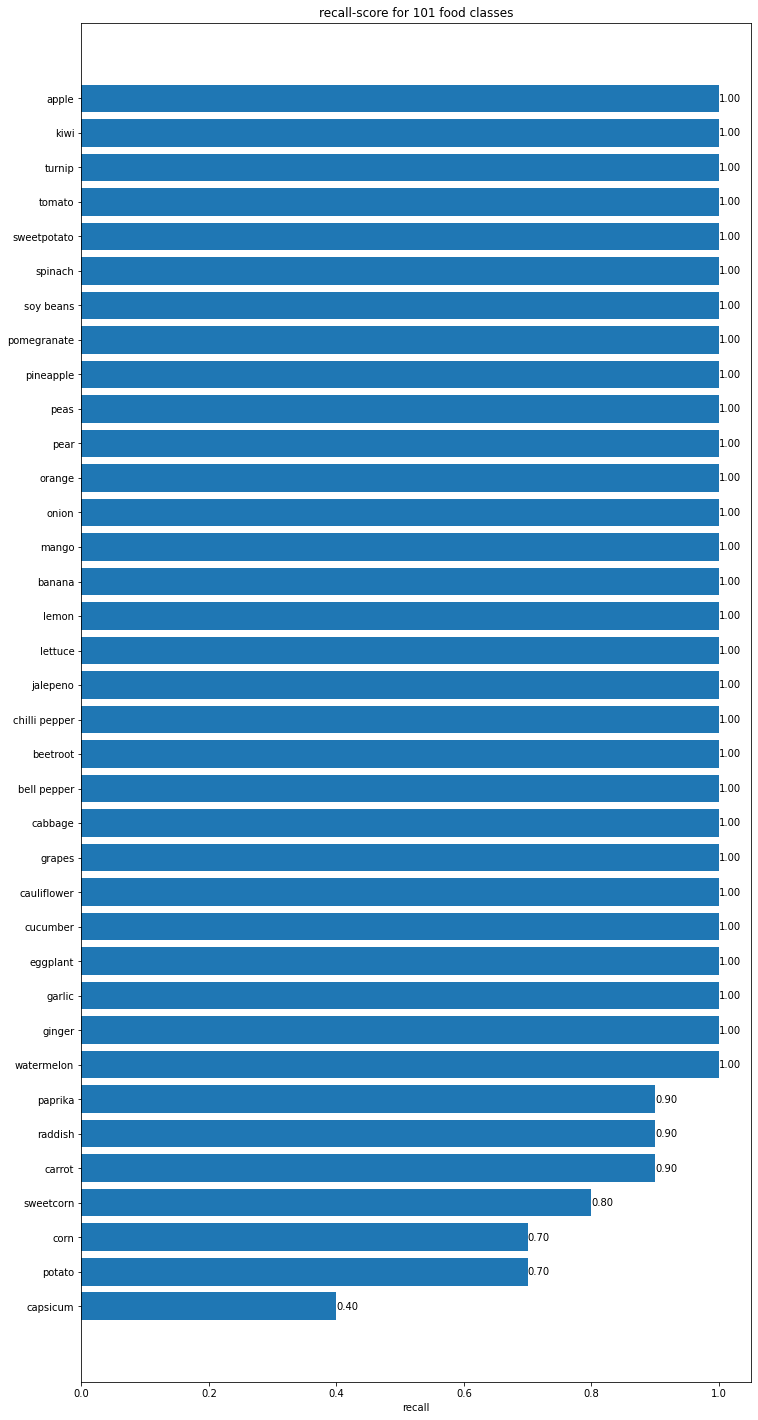

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(recall_scores)), recall_scores["recall"].values)
ax.set_yticks(range(len(recall_scores)))
ax.set_yticklabels(recall_scores["class_names"])
ax.set_xlabel("recall")
ax.set_title("recall-score for 101 food classes")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

In [70]:
class_f1_scores = {}

for k, v in classification_report_dict.items():
    if k == "accuracy": 
        break
    else:
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple': 0.9090909090909091,
 'banana': 1.0,
 'beetroot': 0.9523809523809523,
 'bell pepper': 0.7692307692307693,
 'cabbage': 1.0,
 'capsicum': 0.5714285714285715,
 'carrot': 0.9473684210526316,
 'cauliflower': 1.0,
 'chilli pepper': 1.0,
 'corn': 0.7368421052631577,
 'cucumber': 1.0,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 1.0,
 'jalepeno': 1.0,
 'kiwi': 1.0,
 'lemon': 1.0,
 'lettuce': 1.0,
 'mango': 0.9090909090909091,
 'onion': 1.0,
 'orange': 1.0,
 'paprika': 0.9,
 'pear': 1.0,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 0.8235294117647058,
 'raddish': 0.9473684210526316,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 0.761904761904762,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [71]:
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [72]:
f1_scores[:10]

,class_names,f1-score
18,lettuce,1.0
16,kiwi,1.0
34,turnip,1.0
33,tomato,1.0
32,sweetpotato,1.0
30,spinach,1.0
29,soy beans,1.0
26,pomegranate,1.0
25,pineapple,1.0
24,peas,1.0


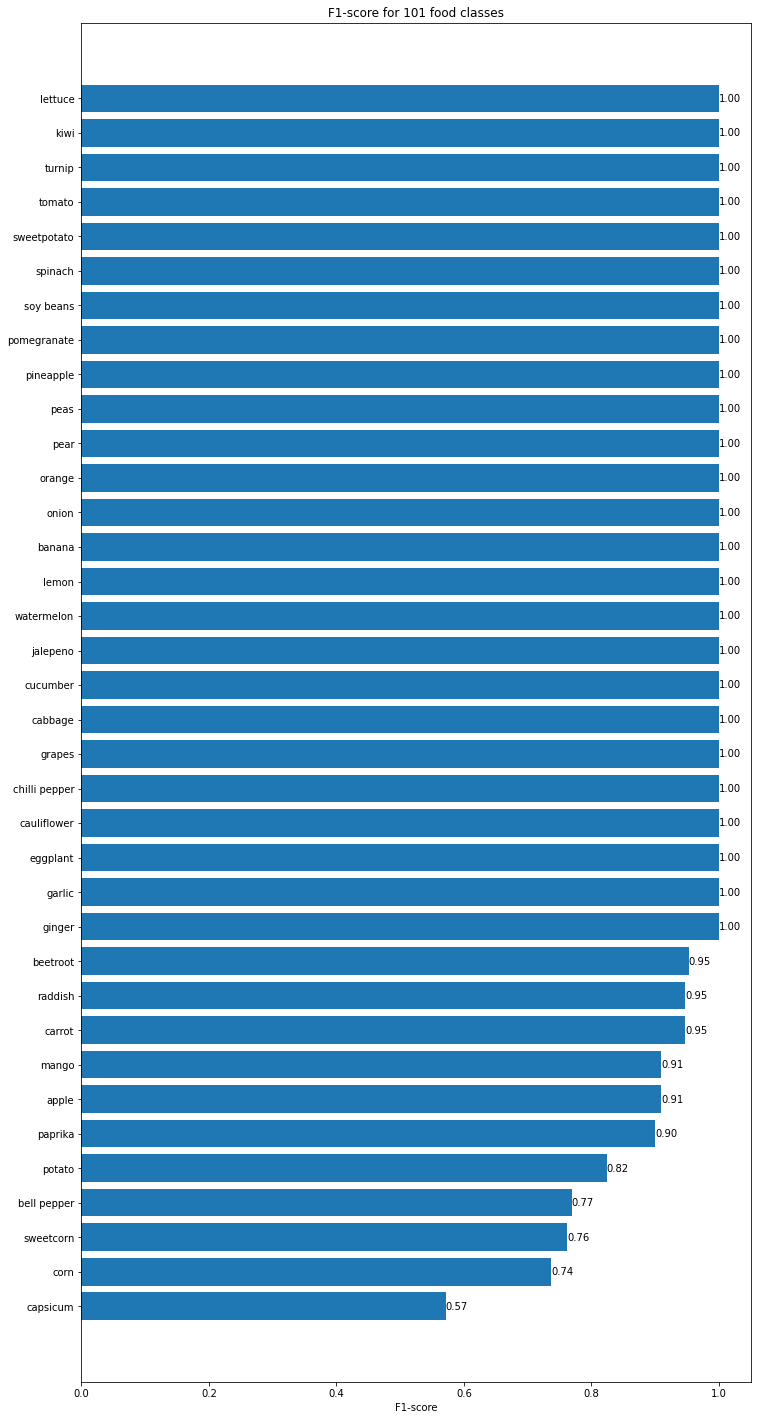

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 food classes")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

#### Visualizing predictions on test images

In [74]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_size=224, scale=True):

    # Read in the image
    img = tf.io.read_file(filename=filename)
    
    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)
    
    # Resize the image
    img = tf.image.resize(img, [img_size, img_size])
    
    # Scaling
    if scale:
        # Rescale the image
        return img/255.
    else:
        return img

1/1 [==============================] - 0s 214ms/step


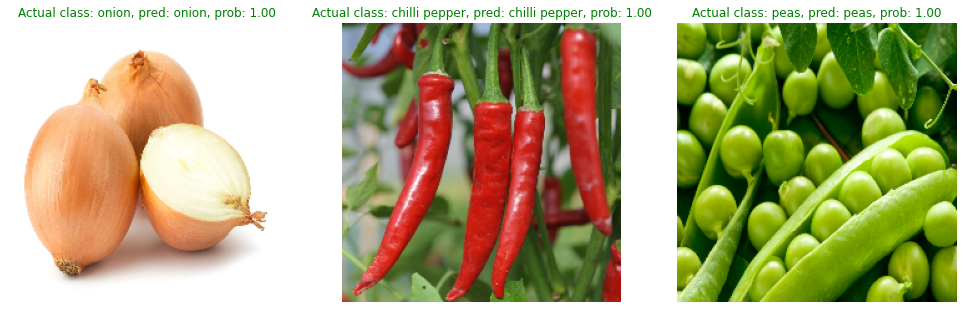

In [75]:
# visualize test images

# Make preds on series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename
    
    # Load the images and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = loaded_model.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()] 
    
    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual class: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);
    

In [ ]:
''' Summary:
            The accuracy of the base model is 91.60%
            The accuracy of the model after unlocking of the last 5 layers is 93.59%
            The accuracy of the model after unlocking the last 10 layers is 94.42%
            The accuracy of the model after unlocking the last 30 layers is 95.26% 
            We can conclude that the accuracy of the model increases as we unlock more layers, run for more epochs and fine-tune our base model '''